In [217]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tqdm

In [238]:
game_stats = pd.read_csv('../csv/game_stats.csv')
game_stats["totalGoals"] = game_stats["home_goals"] + game_stats["away_goals"]
game_stats = game_stats[game_stats["totalGoals"] <= 10]  # remove outliers 99% of games will be kept
del game_stats["Unnamed: 0"]
del game_stats["home_goals"]
del game_stats["away_goals"]
del game_stats["home_powerPlayGoals"]
del game_stats["away_powerPlayGoals"]
del game_stats["home_powerPlayOpportunities"]
del game_stats["away_powerPlayOpportunities"]

game_stats = game_stats.drop_duplicates()
game_stats = game_stats.dropna()

# average game_stats fields starting with home_ and away_ for each row
# home = "home_"
# away = "away_"
# column_names = list(game_stats.columns)




game_stats

,home_pim,home_shots,home_powerPlayPercentage,home_faceOffWinPercentage,home_blocked,home_takeaways,home_giveaways,home_hits,away_pim,away_shots,away_powerPlayPercentage,away_faceOffWinPercentage,away_blocked,away_takeaways,away_giveaways,away_hits,totalGoals
2,10,29,0.0,68.2,17,5,2,23,12,15,33.3,31.8,8,6,4,23,6
5,10,27,0.0,51.6,13,8,16,45,4,40,40.0,48.4,4,3,9,22,4
9,4,41,50.0,41.4,18,4,10,24,4,15,50.0,58.6,11,4,9,13,7
10,2,46,50.0,45.6,9,8,12,29,6,39,0.0,54.4,13,6,6,20,7
11,2,24,66.7,57.1,7,3,19,23,6,34,0.0,42.9,15,9,9,15,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21383,4,32,0.0,52.6,15,5,9,29,8,19,0.0,47.4,23,6,7,33,4
21384,4,23,0.0,43.9,23,14,19,20,6,24,50.0,56.1,17,8,7,13,3
21386,9,32,0.0,63.6,13,4,12,27,9,37,0.0,36.4,17,7,10,27,7
21390,4,37,75.0,49.0,6,3,11,9,8,21,0.0,51.0,10,3,2,17,5


In [219]:
col_names = [col for col in game_stats.columns]
originalGoals = game_stats["totalGoals"]

# z = (x-mean)/std
# x = (z*std)+mean

original_mean = game_stats.mean()
original_std = game_stats.std()

game_stats_normalized =(game_stats-original_mean)/original_std
game_stats = game_stats_normalized
game_stats["totalGoals"] = originalGoals

features = np.array(game_stats.loc[:, game_stats.columns != 'totalGoals'],  dtype='float32')
targets = np.array(game_stats['totalGoals'], dtype='float32')


x_train = features[:int(features.shape[0] * 0.8)]
t_train = targets[:int(targets.shape[0] * 0.8)]

x_test = features[int(features.shape[0] * 0.8):]
t_test = targets[int(targets.shape[0] * 0.8):]


In [241]:
import torch
import torch.nn as nn
import torch.nn.functional as F
torch.set_printoptions(sci_mode=False)
class BobNet(torch.nn.Module):
  def __init__(self):
    super(BobNet, self).__init__()
    self.l1 = nn.Linear(16, 1, bias=True)
    
  def forward(self, x):
    x = self.l1(x)
    return x

loss 3.07 accuracy 0.47: 100%|██████████| 2500/2500 [00:04<00:00, 616.55it/s]


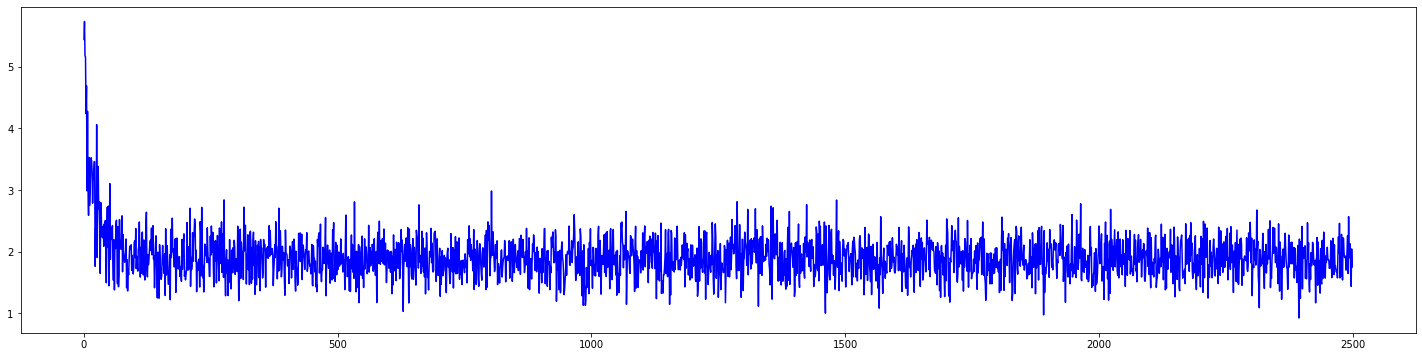

In [242]:
# training
import math
model = BobNet()

loss_function = nn.MSELoss()
optim = torch.optim.Adagrad(model.parameters(), lr=5.0e-1)
BS = 17
losses, accuracies = [], []
t = tqdm.trange(2500)
for i in (t):
  samp = np.random.randint(0, x_train.shape[0], size=(BS))
  X = torch.tensor(x_train[samp].reshape((-1, 16))).float()
  Y = (t_train[samp])
  Y = torch.tensor([[y for y in Y]]).reshape(17, -1).float()
  
  model.zero_grad()
  out = model(X)
  
  # see if cat elements are within 1 of the target
  accuracy = (torch.abs(out - Y) <= 1).float().mean()
  loss = loss_function(out, Y)
  loss = loss.mean()
  loss.backward()
  optim.step()
  loss, accuracy = loss.item(), accuracy.item()
  losses.append(loss)
  accuracies.append(accuracy)
  t.set_description("loss %.2f accuracy %.2f" % (loss, accuracy))
  
  
plt.rcParams["figure.figsize"] = (25, 6)
plt.plot([math.sqrt(loss) for loss in losses], 'b-')
#plt.plot(accuracies)


### Test

In [243]:
model.parameters()

<generator object Module.parameters at 0x7f97f94475f0>

In [244]:
test_results = model.forward(torch.tensor(x_test).float())

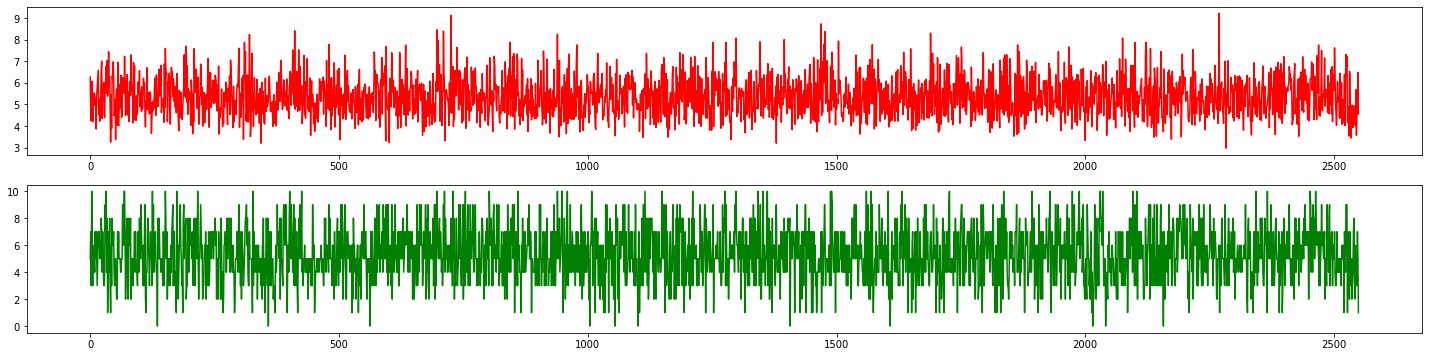

In [245]:
plt.subplot(211)
plt.plot(test_results.detach().numpy().reshape(-1), 'r-')
plt.subplot(212)
plt.plot(t_test, 'g-')

array([[<AxesSubplot:title={'center':'predictions'}>,
        <AxesSubplot:title={'center':'targets'}>]], dtype=object)

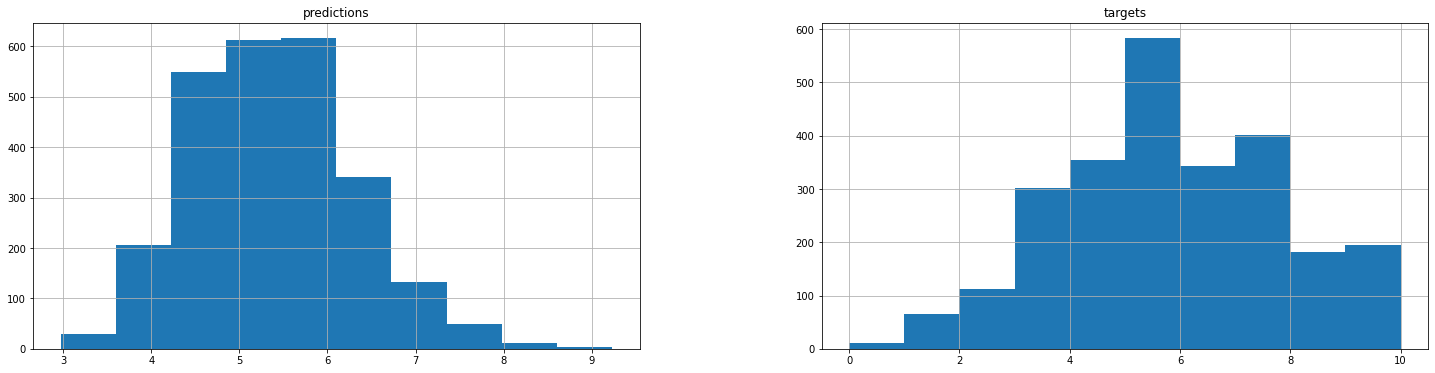

In [246]:
pred_and_targets_df = pd.DataFrame({'predictions': test_results.detach().numpy().reshape(-1), 'targets': t_test})
pred_and_targets_df.hist()